# Рекурентная модель

Модель 2 направлена на предсказание числа продаж в тот или иной день. Данная модель исключает все дни, когда нет продаж и основывется только на тех днях, когда они были. Представляет собой классическую LSTM модель. Архитектура модели представлена на рисунке 5.

In [1]:
import warnings # Чтобы не выводились предупреждения

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import requests
import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import os
%matplotlib inline
from datetime import datetime, timedelta


print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')
warnings.filterwarnings("ignore")

Tensorflow version 2.10.0
GPU is ON


## Этап 1. Преобразование данных

Первым этапом выполняется преобразование входных данных в нужный формат. Функция _delete_duplicte автоматически проверяет набор данных и извлекает дублирующиеся строки, затем суммирует их значения, и удалет лишиние данные.

In [2]:
def _delete_duplicte (df):
    df_2 = df.copy()
    for i in range(1, len(df)):
        if df.iloc[i].date == df.iloc[i-1].date:
            df_2 = df_2.drop(df_2[df_2.date == df.iloc[i].date].index)
            n_count = df.iloc[i]['count'] + df.iloc[i-1]['count']
            new_row = {'date':df.iloc[i].date, 'count':n_count}
            df_2 = df_2.append(new_row, ignore_index=True)
    return df_2

Загружаем данные

In [3]:
df = pd.read_csv('96sku265.csv', sep = ",", parse_dates = ['date'])  #
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)

Преобразуем данные

In [4]:
df = _delete_duplicte(df)
df = df.sort_values(by=['date'])
df = df.reset_index().drop('index', axis=1)
df = df.set_index('date')
df.index.name='date'

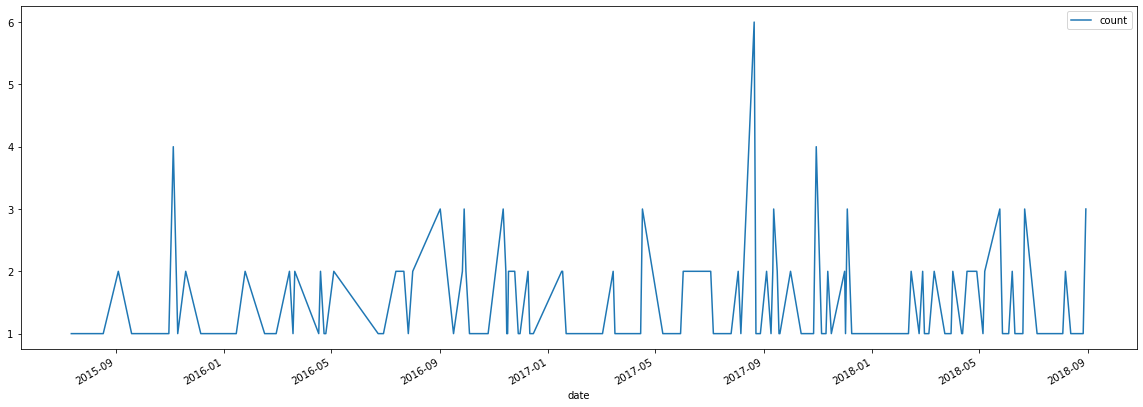

In [5]:
df.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

## Этап 2. Создаем тестовую и тренировочную выборки

In [6]:
t_point = round(0.7*len(df))
train = df.iloc[:t_point]
test = df.iloc[t_point:]

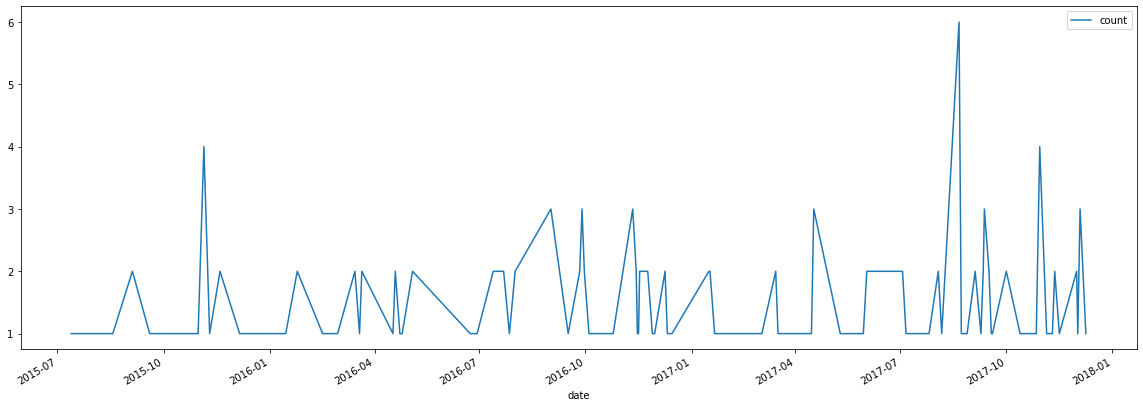

In [7]:
train.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

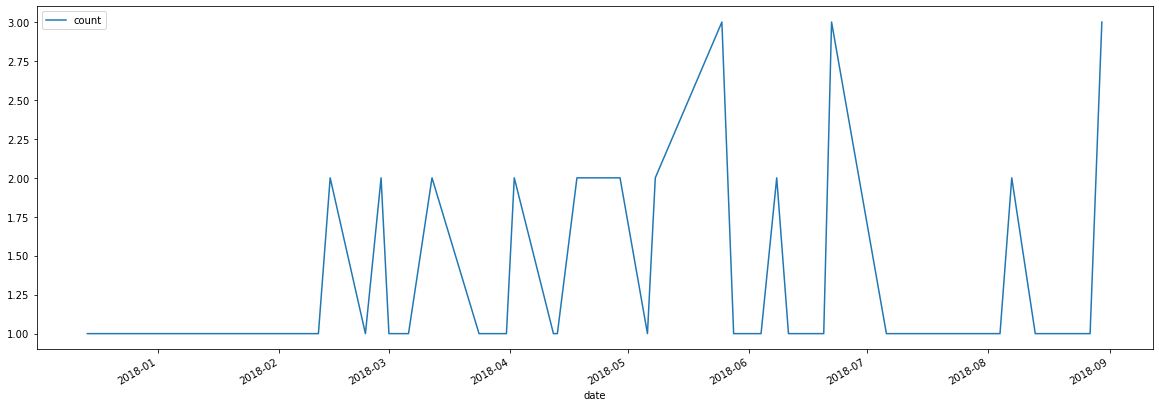

In [8]:
test.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [245]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 10
n_features = 1

generator_train = TimeseriesGenerator(np.array(train), np.array(train), length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(np.array(test), np.array(test), length=n_input, batch_size=1)

X,y = generator_train[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1 1 2 1 1 1 4 1 2 1]
Predict this y: 
 [[1]]


## Создаем модель

In [246]:
def buying_score(y_true, y_pred):
    return (1+y_pred)/(1+y_true)

In [247]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, BatchNormalization, Dropout, Bidirectional, SimpleRNN
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam


model = Sequential()
model.add(Input(shape=(n_input, n_features)))

model.add(Bidirectional(LSTM(60)))
# model.add(Dropout(0.2))

# model.add(Dense(10)) # кол-во нейронов в слое
model.add(Dense(n_features))


model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber(), metrics=['mse', buying_score]) # tf.keras.losses.Huber()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 120)              29760     
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 1)                 121       
                                                                 
Total params: 29,881
Trainable params: 29,881
Non-trainable params: 0
_________________________________________________________________


In [248]:
from keras.callbacks import LearningRateScheduler

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
Checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, min_lr=0.0001)

In [249]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        mse = logs["mse"]
        if (mse <= self.point):
            self.model.stop_training = True


## Выполняем обучение модели

In [250]:
model.fit(generator_train,epochs=1000, callbacks = [StopOnPoint(0.0170)], shuffle = False) 


Epoch 1/1000
99/99 [==============================] - 4s 13ms/step - loss: 0.2693 - mse: 0.7061 - buying_score: 1.0114
Epoch 2/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.2502 - mse: 0.6688 - buying_score: 1.0254
Epoch 3/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.2481 - mse: 0.6668 - buying_score: 1.0264
Epoch 4/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.2469 - mse: 0.6663 - buying_score: 1.0273
Epoch 5/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.2460 - mse: 0.6662 - buying_score: 1.0282
Epoch 6/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.2453 - mse: 0.6659 - buying_score: 1.0290
Epoch 7/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.2447 - mse: 0.6655 - buying_score: 1.0296
Epoch 8/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.2441 - mse: 0.6650 - buying_score: 1.0301
Epoch 9/1000
99/99 [============================

99/99 [==============================] - 1s 13ms/step - loss: 0.0113 - mse: 0.0227 - buying_score: 0.9994
Epoch 138/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.0096 - mse: 0.0193 - buying_score: 1.0036
Epoch 139/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.0184 - mse: 0.0369 - buying_score: 1.0050
Epoch 140/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.0260 - mse: 0.0521 - buying_score: 1.0050
Epoch 141/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.0731 - mse: 0.1462 - buying_score: 1.0075
Epoch 142/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.0315 - mse: 0.0630 - buying_score: 1.0098
Epoch 143/1000
99/99 [==============================] - 1s 12ms/step - loss: 0.0214 - mse: 0.0428 - buying_score: 1.0021
Epoch 144/1000
99/99 [==============================] - 1s 13ms/step - loss: 0.0130 - mse: 0.0260 - buying_score: 1.0078
Epoch 145/1000
99/99 [=========================

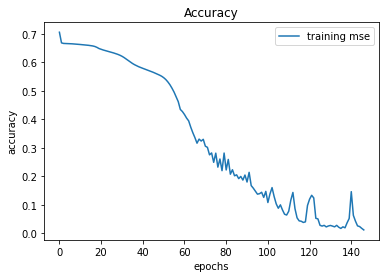

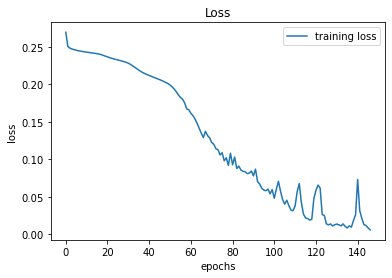

In [251]:
plt.figure(0)
plt.plot(model.history.history['mse'], label='training mse')
# plt.plot(model.history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
# plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [280]:
# model.save('SellsModel.h5')

# Тестируем полученную модель

## Эксперимент 1

Первым этапом тестируем полученную модель на тестовой выборке

In [252]:
test_predictions = []
first_eval_batch = np.array(test)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    test_predictions.append(np.array(test)[i]) 
    
try:
    for i in range(len(test)-3):
        current_pred = model.predict(current_batch)[0]
        print(current_pred)
        current_pred = round(current_pred[0])
        print(current_pred)
        test_predictions.append([current_pred])
        current_batch = np.append(current_batch[:,1:,:],[[np.array(test)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 1s 658ms/step
[1.4337957]
1
1/1 [==============================] - 0s 17ms/step
[1.0221139]
1
1/1 [==============================] - 0s 18ms/step
[1.8666568]
2
1/1 [==============================] - 0s 18ms/step
[1.5834082]
2
1/1 [==============================] - 0s 18ms/step
[0.8800163]
1
1/1 [==============================] - 0s 18ms/step
[0.88350946]
1
1/1 [==============================] - 0s 19ms/step
[1.9544741]
2
1/1 [==============================] - 0s 17ms/step
[1.1262234]
1
1/1 [==============================] - 0s 17ms/step
[0.883377]
1
1/1 [==============================] - 0s 17ms/step
[2.1647196]
2
1/1 [==============================] - 0s 17ms/step
[2.1360497]
2
1/1 [==============================] - 0s 17ms/step
[1.2358984]
1
1/1 [==============================] - 0s 17ms/step
[1.4957765]
1
1/1 [==============================] - 0s 17ms/step
[0.9406535]
1
1/1 [==============================] - 0s 17ms/step
[2.2665443]
2
1/1 [====

In [253]:
test_copy = test.copy()
test_copy['Predictions'] = np.array(test_predictions)
test_copy

,count,Predictions
date,,
2017-12-14,1,1
2017-12-28,1,1
2018-01-01,1,1
2018-01-15,1,1
2018-01-17,1,1
2018-01-25,1,1
2018-02-07,1,1
2018-02-11,1,1
2018-02-14,2,2


<AxesSubplot:xlabel='date'>

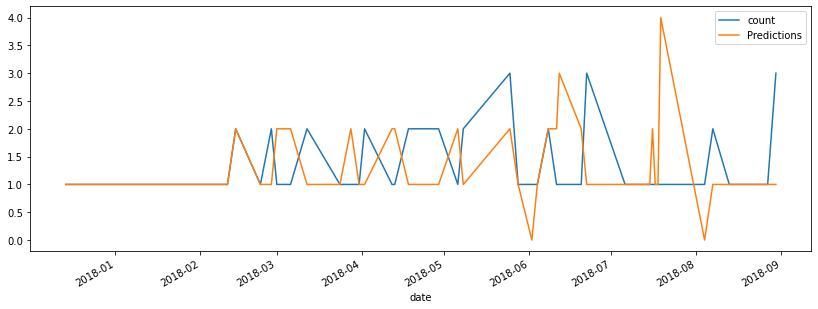

In [254]:
test_copy.plot(figsize=(14,5))


In [255]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy['count']),list(test_copy['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))
    
mean(metric_list)    

1.0443262411347518

In [256]:
Bought = sum(list(test_copy['Predictions'][n_input:]))
Sold = sum(list(test_copy['count'][n_input:]))
Bought, Sold

(51, 52)

In [257]:
print('Перезакуп {}'.format (Bought - Sold)) if Bought/Sold > 1 else print('Недозакуп {}'.format (Bought - Sold))

Недозакуп -1


In [258]:
Bought/Sold

0.9807692307692307

## Эксперимент 2
Выполняем предсказание на 40 дней вперед для артикула с высокочастотной номенклуатурой

In [259]:
new_predictions = []
first_eval_batch = np.array(test)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)[0]
        current_pred = round(current_pred[0])
        print(current_pred)
        new_predictions.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 18ms/step
2
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 17ms/step
2
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 17ms/step
3
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 16ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 17ms/step
1
1/1 [==============================] - 0s 26ms/step
2
1/1 [==============================] - 0s 17ms/step
2
1/1 [==============================] - 0s 17ms/step
2
1/1 [=======================

In [260]:
test_copy_3 = test.copy()
test_copy_3

,count
date,
2017-12-14,1
2017-12-28,1
2018-01-01,1
2018-01-15,1
2018-01-17,1
2018-01-25,1
2018-02-07,1
2018-02-11,1
2018-02-14,2


In [261]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy_3.reset_index().date)[-1]+ datetime.timedelta(days=i))

In [262]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions
predicted_df = predicted_df.set_index('date')

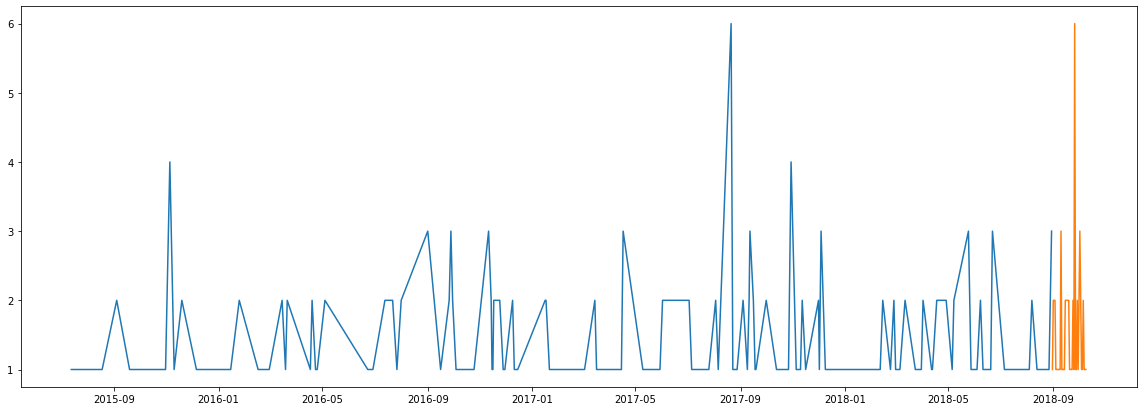

In [263]:
plt.figure(figsize = (20, 7))
plt.plot(df)
plt.plot(predicted_df)
plt.show()

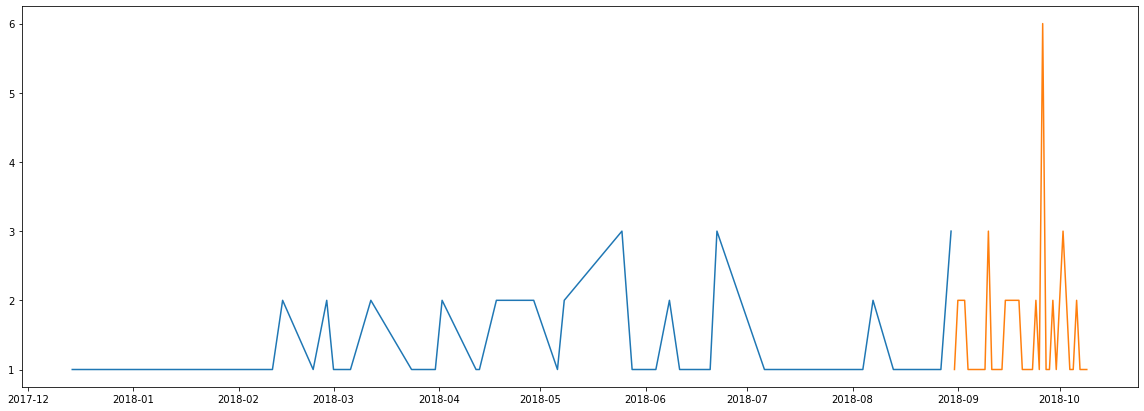

In [264]:
plt.figure(figsize = (20, 7))
plt.plot(test_copy_3)
plt.plot(predicted_df)
plt.show()

## Эксперимент 3
Тестируем полученную модель на наборе данных с низкочастотной номенклуатурой

In [265]:
df_2 = pd.read_csv('42sku13653.csv', sep = ",", parse_dates = ['date'])

In [266]:
df_2 = df_2.sort_values(by=['date'])
df_2 = df_2.reset_index().drop('index', axis=1)

In [267]:
date = df_2['date']
df_2 = df_2.set_index('date')

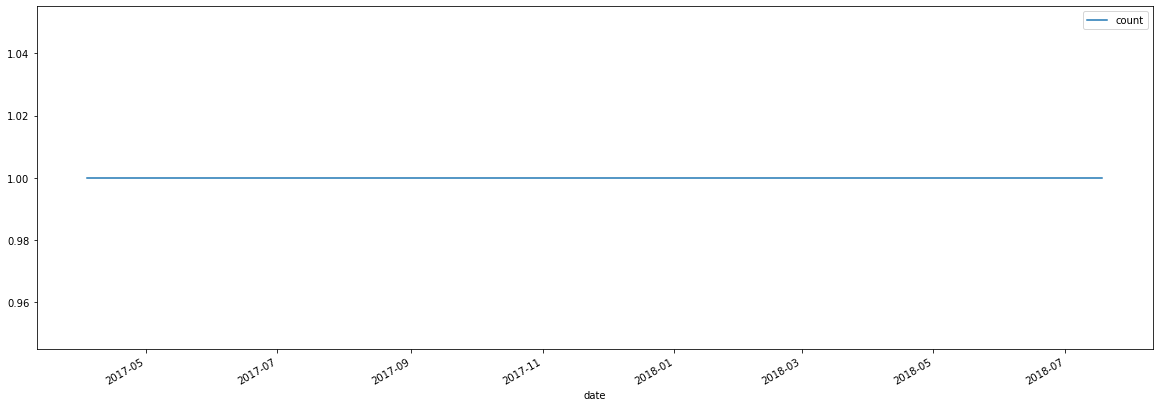

In [268]:
df_2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [269]:
df2_predictions = []
first_eval_batch = np.array(df_2)[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(n_input-1):
    df2_predictions.append(np.array(df_2)[i]) 
    
try:
    for i in range(len(test)-3):
        current_pred = model.predict(current_batch)[0]
        current_pred = round(current_pred[0])
        df2_predictions.append([current_pred])
        current_batch = np.append(current_batch[:,1:,:],[[np.array(df_2)[n_input+i]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 17ms/step


In [270]:
test_copy_DF2 = df_2.copy()

test_copy_DF2['Predictions'] = np.array(df2_predictions)
test_copy_DF2


,count,Predictions
date,,
2017-04-04,1,1
2017-04-24,1,1
2017-06-05,1,1
2017-07-02,1,1
2017-11-13,1,1
2017-11-14,1,1
2017-12-01,1,1
2017-12-07,1,1
2018-01-09,1,1


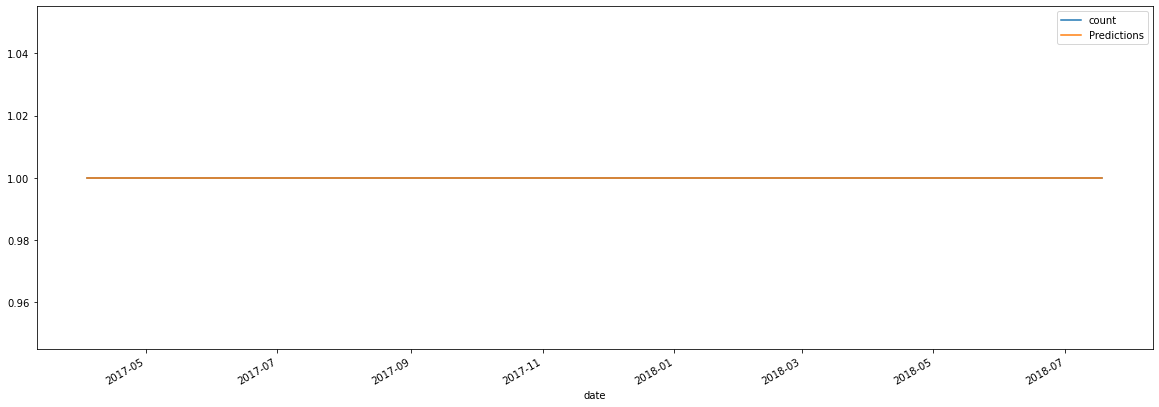

In [271]:
test_copy_DF2.plot()
fig = plt.gcf() 
fig.set_size_inches(20,7) # Меняет размер графика

In [272]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(test_copy_DF2['count'],test_copy_DF2['Predictions'])

0.0

In [273]:
from statistics import mean
metric_list = []
for y_true, y_pred in zip(list(test_copy_DF2['count']),list(test_copy_DF2['Predictions'])):
    metric_list.append(buying_score(y_true, y_pred))
    
mean(metric_list)    

1.0

## Эксперимент 4
Выполняем предсказание на 40 дней вперед для артикула с низкоочастотной номенклуатурой

In [274]:
new_predictions_2 = []
first_eval_batch = np.array(df_2)[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
try:
    for i in range(40):
        current_pred = model.predict(current_batch)[0]
        current_pred = round(current_pred[0])
        new_predictions_2.append(current_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
except:
    pass

1/1 [==============================] - 0s 17ms/step


In [275]:
test_copy2_DF2 = df_2.copy()


In [276]:
import datetime
new_data_list = []
for i in range(1, 41):
    new_data_list.append(list(test_copy2_DF2.reset_index().date)[-1]+ datetime.timedelta(days=i))

In [277]:
predicted_df=pd.DataFrame({'date':new_data_list})
predicted_df['count'] = new_predictions_2
predicted_df = predicted_df.set_index('date')

In [278]:
predicted_df

,count
date,
2018-07-19,1
2018-07-20,1
2018-07-21,1
2018-07-22,1
2018-07-23,1
2018-07-24,1
2018-07-25,1
2018-07-26,1
2018-07-27,1


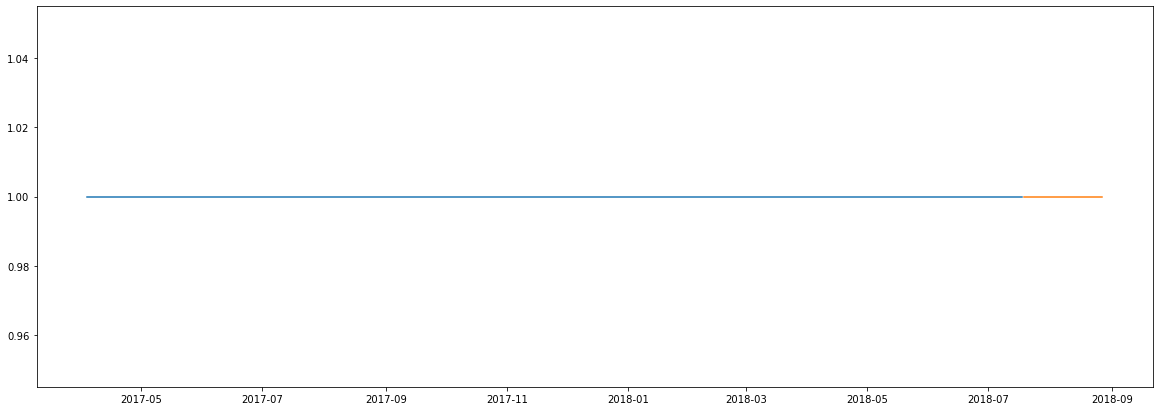

In [279]:
plt.figure(figsize = (20, 7))
plt.plot(df_2)
plt.plot(predicted_df)
plt.show()